In [292]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import tqdm_notebook as tqdm

from echo_state_tests import gen_in_out_one_in_subs

from scipy.sparse import csr_matrix

from esn_module import esn

In [534]:
N = 500

cf = .1
cf_in = 1.

sigm_w = 1.
sigm_w_in = 1.

W = np.random.normal(0.,sigm_w/(cf*N)**.5,(N,N))*(np.random.rand(N,N) <= cf)
W[range(0),range(0)] = 0.

WT = W.T

w_in = np.random.normal(0.,sigm_w_in,(N))*(np.random.rand(N) <= cf_in)

###
eps_w_out = 0.01
eps_a = .5

## alpha = 0.: only local gradients, 1.: only pop. average gradient.
alpha = .95


###
T = 50000
T_skip_rec = 10
T_rec = int(T/T_skip_rec)
T_w_o_learn = 100
T_skip_w_o_learn = 100

y_rec = np.ndarray((T_rec,N))
a_rec = np.ndarray((T_rec,N))
w_out_rec = np.ndarray((T_rec,N+1))

y_rec_w_out_learn = np.zeros((T_w_o_learn,N+1))

###
reg_fact = 0.01



In [535]:
E_rec = np.ndarray((T_rec))

In [536]:
u_in, u_out = gen_in_out_one_in_subs(T,5)
u_in = np.array([u_in]).T
u_out = np.array([u_out]).T

In [552]:
'''
y = np.random.rand(N+1)-.5
y[0] = 1.

a = np.ones((N))*2.

w_out = np.random.rand(N+1)-.5
w_out[0] = 0.

H = np.zeros((N,N))
G = np.zeros((N,N))
F = np.zeros((N,N))
'''
for t in tqdm(range(T)):
    
    X = W @ y[1:] + w_in*u_in[t]
    
    y[1:] = np.tanh(a*X)
    
    y_rec_w_out_learn[:-1,:] = y_rec_w_out_learn[1:,:]
    y_rec_w_out_learn[-1,:] = y[:]
    
    if t>=T_w_o_learn:
    
        F[range(N),range(N)] = (1.-y[1:]**2.)*X
        H = (WT * a * (1.-y[1:]**2.)).T
        G = H @ G + F

        O = y @ w_out

        #nabl_w_out = (O - u_out[t])*y

        nabl_a = (O - u_out[t])*(w_out[1:] @ G)

        #w_out -= eps_w_out * nabl_w_out

        a -= eps_a * (nabl_a * (1.-alpha) + alpha * nabl_a.mean())

        a = np.maximum(a,0.001)
    
    if t%T_skip_w_o_learn == 0 and t>=T_w_o_learn:
        
        w_out = (np.linalg.inv(y_rec_w_out_learn.T @ y_rec_w_out_learn + reg_fact*np.eye(N+1)) @ y_rec_w_out_learn.T @ u_out[t-T_w_o_learn+1:t+1,:])[:,0]
        
    
    ####
    if t%T_skip_rec == 0:
        
        t_rec = int(t/T_skip_rec)
        
        y_rec[t_rec,:] = y[1:]
        a_rec[t_rec,:] = a
        w_out_rec[t_rec,:] = w_out
        
        E_rec[t_rec] = (O - u_out[t])**2./2.
    
w_out = (np.linalg.inv(y_rec_w_out_learn.T @ y_rec_w_out_learn + reg_fact*np.eye(N+1)) @ y_rec_w_out_learn.T @ u_out[t-T_w_o_learn+1:t+1,:])[:,0]    
        
        
ESN = esn(N=N)
ESN.W = csr_matrix(W)
ESN.w_in = np.array([w_in]).T
ESN.w_out = np.array([w_out])
ESN.gain = a

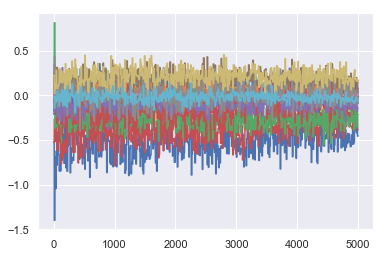

In [553]:
plt.plot(w_out_rec[:,:20])
plt.show()

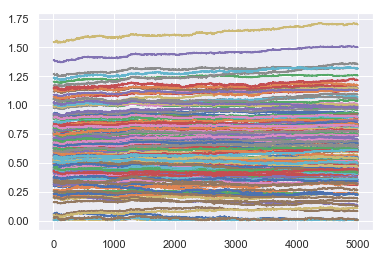

In [554]:
plt.plot(a_rec[:,:200])
plt.show()

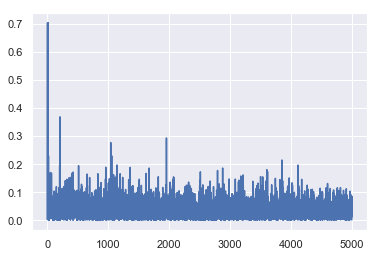

In [555]:
plt.plot(E_rec**.5)
#plt.ylim([0.,10.])
plt.show()

In [574]:
u_in_test,u_out_test = gen_in_out_one_in_subs(T,5)

ESN_unpert = esn(N=500)
ESN_unpert.learn_w_out(u_in,u_out)

ESN.learn_w_out(u_in,u_out)

u_pred = ESN.predict_data(u_in_test)

u_pred_unpert = ESN_unpert.predict_data(u_in_test)

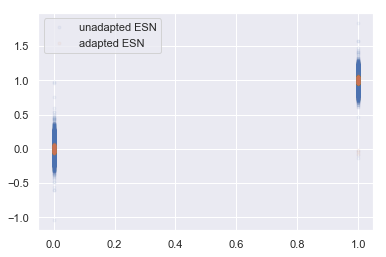

In [575]:
plt.plot(u_out_test,u_pred_unpert,'.',alpha=0.05,label="unadapted ESN")
plt.plot(u_out_test,u_pred,'.',alpha=0.05,label="adapted ESN")
plt.legend()
plt.show()

In [572]:
l_unpert = np.linalg.eigvals(ESN_unpert.W_gain())
l_adapt = np.linalg.eigvals(ESN.W_gain())

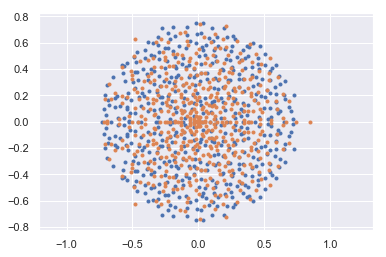

In [573]:
plt.plot(l_unpert.real,l_unpert.imag,'.')
plt.plot(l_adapt.real,l_adapt.imag,'.')
plt.axis("equal")
plt.show()